In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import utils

## Reading in Data

In [3]:
# Reading in the dataframe and converting to dates and floats
btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
btc_ar = btc_df.values

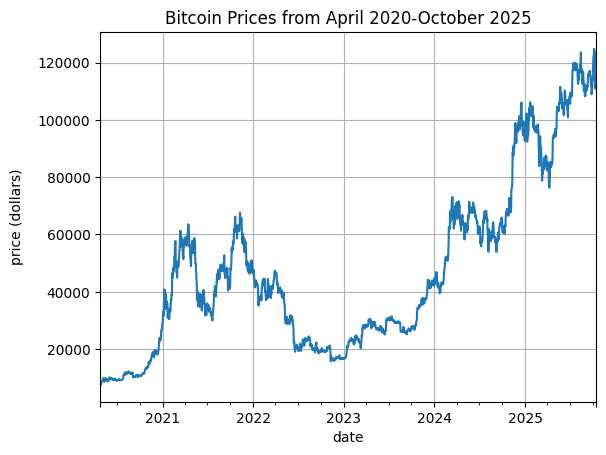

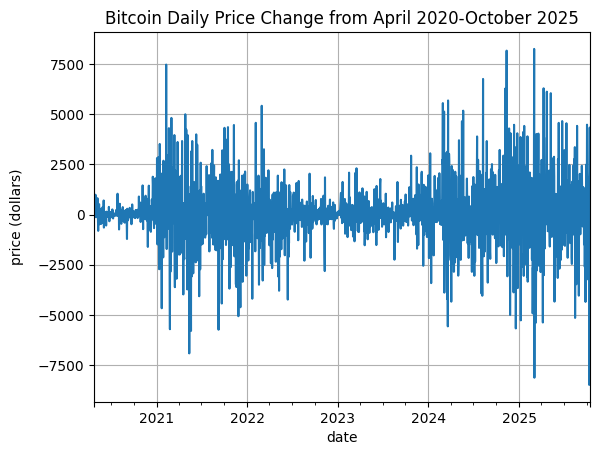

In [6]:
# Plotting the initial bitcoin data
ax = btc_df["price"].plot()
plt.title("Bitcoin Prices from April 2020-October 2025")
plt.ylabel("price (dollars)", labelpad=10)
plt.grid(True)
plt.savefig("Pictures/price_data.png", dpi=300, bbox_inches="tight")
plt.show()

# Plotting the daily price change feature
ax = btc_df["price_diff"].plot()
plt.title("Bitcoin Daily Price Change from April 2020-October 2025")
plt.ylabel("price (dollars)", labelpad=10)
plt.grid(True)
plt.savefig("Pictures/price_diff_data.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary Statistics

In [9]:
# Computing the frequency at which prices rose between days
print(sum(btc_df["price_diff"] > 0) / len(btc_df))

# Determining the average change when prices go up and when they go down
print(btc_df[btc_df["price_diff"] > 0]["price_diff"].mean())
print(btc_df[btc_df["price_diff"] < 0]["price_diff"].mean())

# Determining general summary statistics
btc_df.describe()

0.515
979.6713203883497
-932.3016305469556


,price,price_diff
count,2000.000000,1999.000000
mean,47525.415810,52.857019
std,29942.095085,1498.785259
min,7495.390000,-8496.290000
25%,23823.277500,-469.650000
50%,40508.710000,22.700000
75%,63346.122500,586.215000
max,124773.510000,8256.270000


# Trees & Random Forests

# Autoregressive Linear Regression